In [212]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
def get_model_summaries(predictions, actuals, labels, model_name):
    actuals = [labels[actual] for actual in np.argmax(actuals, axis = 1)]
    loss = log_loss(actuals, predictions)
    predictions = [labels[prediction] for prediction in np.argmax(predictions, axis = 1)]
    accuracy = accuracy_score(actuals, predictions)
    precision_weighted = precision_score(actuals, predictions, labels=labels, average='weighted')
    recall_weighted = recall_score(actuals, predictions, labels=labels, average='weighted')
    f1_weighted = f1_score(actuals, predictions, labels=labels, average='weighted')
    return [model_name, loss, accuracy, precision_weighted, recall_weighted, f1_weighted]

In [214]:
def model_evaluation(predictions, y, column_labels, label):
    y = [labels[actual] for actual in np.argmax(y, axis = 1)]
    #calculate loss
    loss = log_loss(y, predictions)
    print('{0} Loss: {1:.4f}'.format(label, loss))
    predictions = [labels[prediction] for prediction in np.argmax(predictions, axis = 1)]
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision_weighted = precision_score(y, predictions, labels=column_labels, average='weighted')
    print('{0} Precision - Weighted: {1:.4f}'.format(label, precision_weighted))
    #calculate recall
    recall_weighted = recall_score(y, predictions, labels=column_labels, average='weighted')
    print('{0} Recall - Weighted: {1:.4f}'.format(label, recall_weighted))
    #calculate f1
    f1_weighted = f1_score(y, predictions, labels=column_labels, average='weighted')
    print('{0} F1 - Weighted: {1:.4f}'.format(label, f1_weighted))    
    cm = confusion_matrix(y, predictions)
    df_cm = np.transpose(np.transpose(cm) / cm.astype(np.float).sum(axis=1))
    df_cm = pd.DataFrame(df_cm, index = column_labels, columns = column_labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(label + ' - Confusion Matrix')
    plt.show()

In [239]:
def plot_roc(model_list, model_names, actual, labels, title):
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    for i, predictions in enumerate(model_list):
        fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]], _ = roc_curve(actual.ravel(), predictions.ravel())
        roc_auc["micro - " + model_names[i]] = auc(fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]])
    plt.figure(figsize=(10,10))
    colors = 'bgrym'
    for i, color in zip(fpr.keys(), colors):
        plt.plot(fpr[i], tpr[i], color=color, linestyle=':',
                 label='ROC curve of {0} (area = {1:0.4f})'
                 ''.format(i.split(' - ')[1], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [216]:
labels = pd.read_csv('train_w_poster_updated_genres.csv')['genre']
labels = sorted(labels.unique())
y_train = np.load('train_outcome_keras.npy')
y_test = np.load('test_outcome_keras.npy')
rf = pd.read_csv('../../Milestone 3/Random Forest_probabilities.csv')
rf = rf.as_matrix()
rf_no_cluster = pd.read_csv('../../Milestone 3/RF_No Clusters_probabilities.csv')
rf_no_cluster = rf_no_cluster.as_matrix()
rf_top_10 = pd.read_csv('../../Milestone 3/RF_Top 10 Predictors_probabilities.csv')
rf_top_10 = rf_top_10.as_matrix()
xgb = pd.read_csv('../../Milestone 3/XGBoost_probabilities.csv')
xgb = xgb.as_matrix()

In [217]:
predictions = os.listdir('predictions/')
predictions = [prediction for prediction in predictions if np.load('predictions/' + prediction).shape[1]==8]

In [218]:
train_predictions = [prediction for prediction in predictions if 'test' not in prediction]
test_predictions = [prediction for prediction in predictions if 'test' in prediction]

In [219]:
train_scores = []
for prediction in train_predictions:
    prediction_matrix = np.load('predictions/' + prediction)
    train_scores.append(get_model_summaries(prediction_matrix, y_train, labels, prediction))
train_summary_df = pd.DataFrame(train_scores, columns  = ['model_name', 'loss', 'accuracy', 'precision', 'recall', 'f1'])

In [220]:
test_scores = []
for prediction in test_predictions:
    prediction_matrix = np.load('predictions/' + prediction)
    test_scores.append(get_model_summaries(prediction_matrix, y_test, labels, prediction))
test_scores.append(get_model_summaries(rf, y_test, labels, 'random forest'))
test_scores.append(get_model_summaries(xgb, y_test, labels, 'xgboost'))
test_summary_df = pd.DataFrame(test_scores, columns  = ['model_name', 'loss', 'accuracy', 'precision', 'recall', 'f1'])

In [221]:
train_summary_df

,model_name,loss,accuracy,precision,recall,f1
0,model_47_combined_train_predictions.npy,1.142122,0.564410,0.558174,0.564410,0.554444
1,model_48_train_predictions.npy,1.663048,0.345148,0.414806,0.345148,0.198251
2,model_49_image_train_predictions.npy,22.989266,0.334393,0.111818,0.334393,0.167594
3,model_50_image_train_predictions.npy,1.853908,0.334393,0.111818,0.334393,0.167594
4,model_51_metadata_train_predictions.npy,1.155935,0.560865,0.556345,0.560865,0.550554
5,model_52_combined_train_predictions.npy,1.179994,0.551088,0.545236,0.551088,0.538013
6,model_52_image_train_predictions.npy,1.853886,0.334393,0.111818,0.334393,0.167594
7,model_53_image_train_predictions.npy,1.757863,0.332193,0.145770,0.332193,0.177453
8,model_53_pretrained_train_predictions.npy,22.989266,0.334393,0.111818,0.334393,0.167594
9,model_54_image_train_predictions.npy,30.701604,0.111098,0.012343,0.111098,0.022217


In [222]:
test_summary_df

,model_name,loss,accuracy,precision,recall,f1
0,model_47_combined_test_predictions.npy,1.503333,0.451788,0.447104,0.451788,0.443845
1,model_48_test_predictions.npy,1.802223,0.341917,0.200591,0.341917,0.185148
2,model_49_image_test_predictions.npy,22.610793,0.345351,0.119267,0.345351,0.177302
3,model_50_image_test_predictions.npy,1.841366,0.345351,0.119267,0.345351,0.177302
4,model_51_metadata_test_predictions.npy,1.524408,0.444349,0.440032,0.444349,0.434043
5,model_52_combined_test_predictions.npy,1.492047,0.456938,0.445560,0.456938,0.442526
6,model_52_image_test_predictions.npy,1.841282,0.345351,0.119267,0.345351,0.177302
7,model_53_image_test_predictions.npy,1.796107,0.344492,0.154776,0.344492,0.189674
8,model_53_pretrained_test_predictions.npy,22.610793,0.345351,0.119267,0.345351,0.177302
9,model_54_image_test_predictions.npy,30.837565,0.107010,0.011451,0.107010,0.020688


In [223]:
chosen_models = ['model_52_combined_', 'model_56_image_', 'model_54_pretrained_']

### Confusion matrices for train and test of chosen models

model_52_combined_train Loss: 1.1800
model_52_combined_train Accuracy: 0.5511
model_52_combined_train Precision - Weighted: 0.5452
model_52_combined_train Recall - Weighted: 0.5511
model_52_combined_train F1 - Weighted: 0.5380


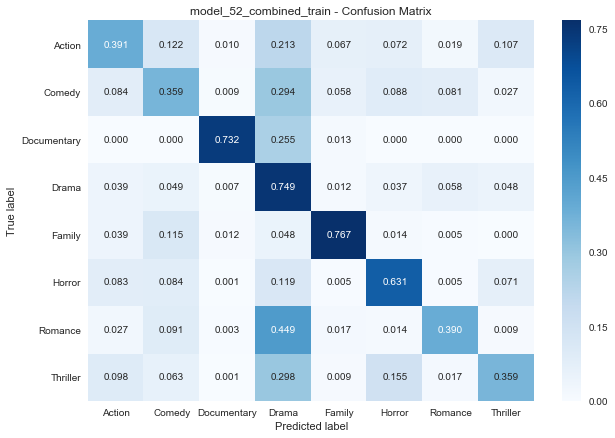

model_52_combined_test Loss: 1.4920
model_52_combined_test Accuracy: 0.4569
model_52_combined_test Precision - Weighted: 0.4456
model_52_combined_test Recall - Weighted: 0.4569
model_52_combined_test F1 - Weighted: 0.4425


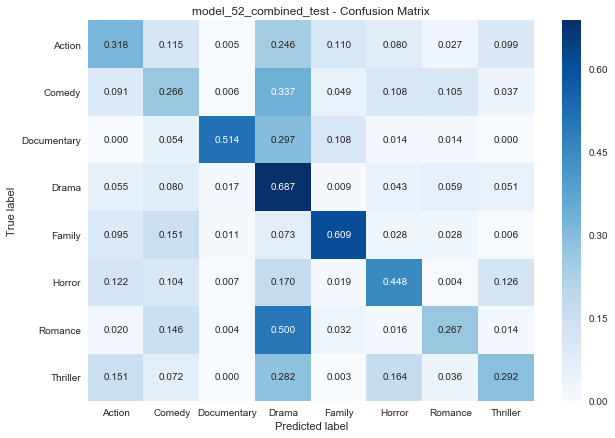

model_56_image_train Loss: 1.8538
model_56_image_train Accuracy: 0.3344
model_56_image_train Precision - Weighted: 0.1118
model_56_image_train Recall - Weighted: 0.3344
model_56_image_train F1 - Weighted: 0.1676


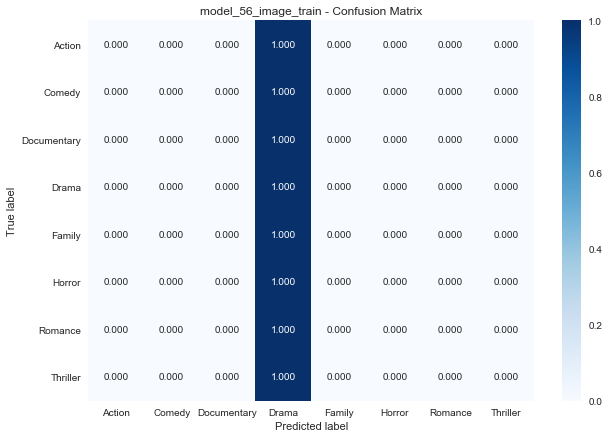

model_56_image_test Loss: 1.8412
model_56_image_test Accuracy: 0.3454
model_56_image_test Precision - Weighted: 0.1193
model_56_image_test Recall - Weighted: 0.3454
model_56_image_test F1 - Weighted: 0.1773


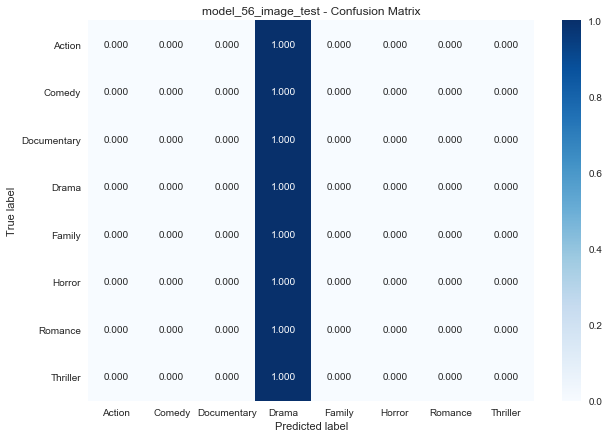

model_54_pretrained_train Loss: 22.9893
model_54_pretrained_train Accuracy: 0.3344
model_54_pretrained_train Precision - Weighted: 0.1118
model_54_pretrained_train Recall - Weighted: 0.3344
model_54_pretrained_train F1 - Weighted: 0.1676


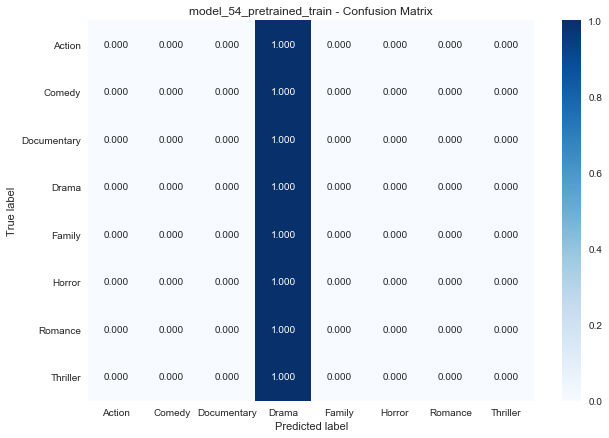

model_54_pretrained_test Loss: 22.6108
model_54_pretrained_test Accuracy: 0.3454
model_54_pretrained_test Precision - Weighted: 0.1193
model_54_pretrained_test Recall - Weighted: 0.3454
model_54_pretrained_test F1 - Weighted: 0.1773


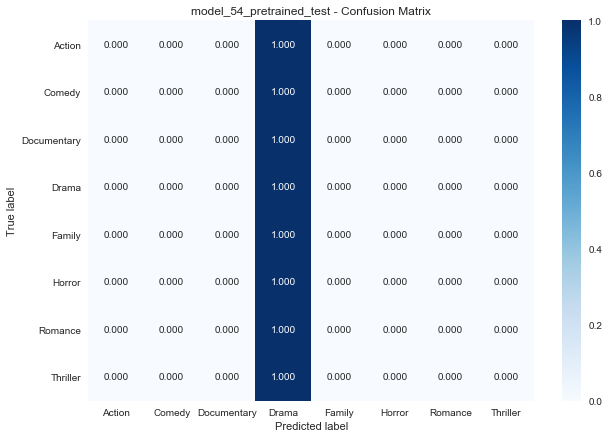

In [224]:
for model in chosen_models:
    for t in ['train', 'test']:
        y = y_train if t == 'train' else y_test
        model_evaluation(np.load('predictions/' + model + t + '_predictions.npy'),
                         y, labels, model + t)

### Comparison of combined vs. image vs. pre-trained

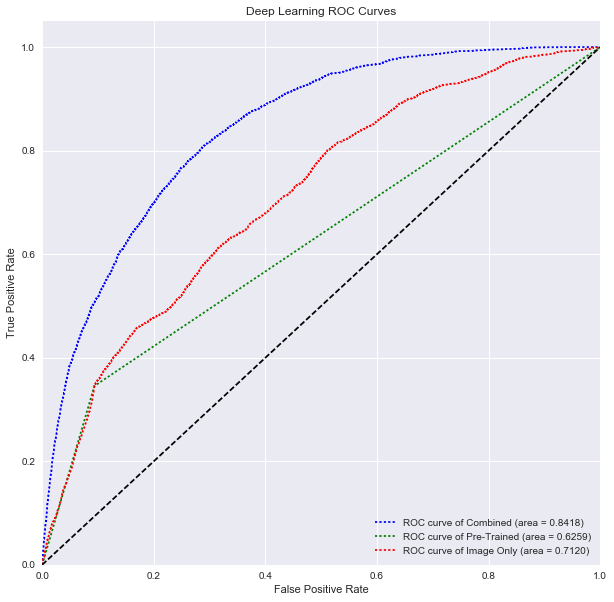

In [225]:
chosen_model_names = ['model_52_combined_test_predictions.npy', 'model_56_image_test_predictions.npy', 'model_54_pretrained_test_predictions.npy']
chosen_model_predictions = [np.load('predictions/' + model) for model in chosen_model_names]
plot_roc(chosen_model_predictions, ['Combined', 'Image Only', 'Pre-Trained'], y_test, labels, 'Deep Learning ROC Curves')

### Combined models that were run, shows that metadata drives all accuracy

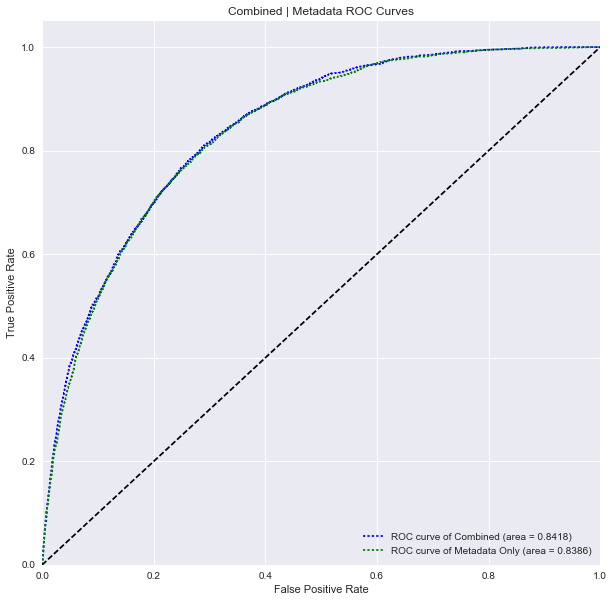

In [226]:
chosen_model_names = ['model_52_combined_test_predictions.npy', 'model_51_metadata_test_predictions.npy']
chosen_model_predictions = [np.load('predictions/' + model) for model in chosen_model_names]
plot_roc(chosen_model_predictions, ['Combined', 'Metadata Only'], y_test, labels, 'Combined | Metadata ROC Curves')

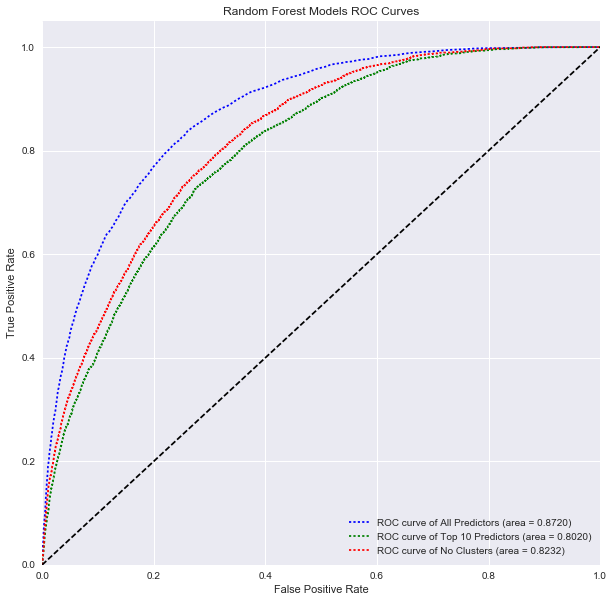

In [227]:
plot_roc([rf, rf_no_cluster, rf_top_10], ['All Predictors', 'No Clusters', 
                                         'Top 10 Predictors'], y_test, labels, 'Random Forest Models ROC Curves')

Random Forest Loss: 1.3665
Random Forest Accuracy: 0.5104
Random Forest Precision - Weighted: 0.5139
Random Forest Recall - Weighted: 0.5104
Random Forest F1 - Weighted: 0.4764


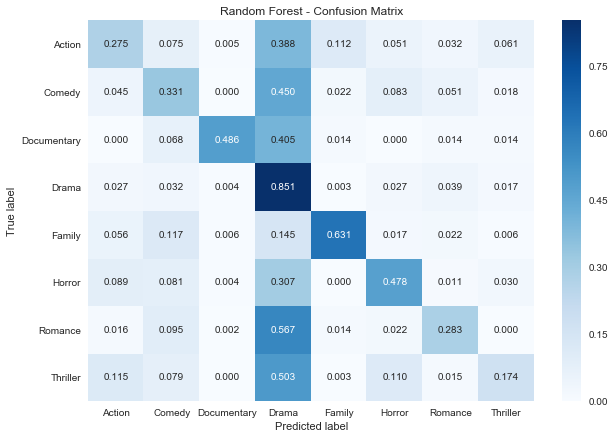

XGBoost Loss: 1.3722
XGBoost Accuracy: 0.5056
XGBoost Precision - Weighted: 0.4928
XGBoost Recall - Weighted: 0.5056
XGBoost F1 - Weighted: 0.4909


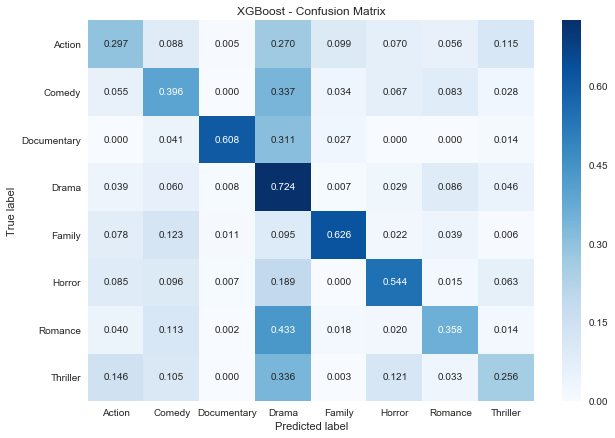

In [228]:
model_evaluation(rf,y_test, labels, 'Random Forest')
model_evaluation(xgb,y_test, labels, 'XGBoost')

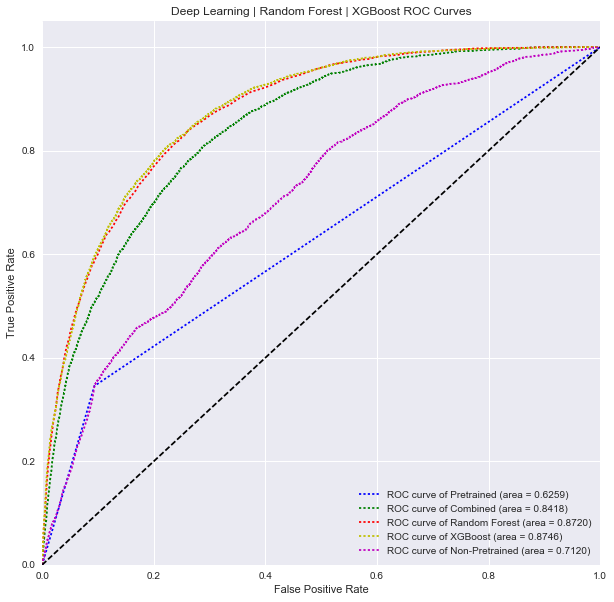

In [240]:
chosen_model_names = ['model_52_combined_test_predictions.npy', 'model_56_image_test_predictions.npy', 'model_54_pretrained_test_predictions.npy']
chosen_model_predictions = [np.load('predictions/' + model) for model in chosen_model_names]
chosen_model_predictions.append(rf)
chosen_model_predictions.append(xgb)
plot_roc(chosen_model_predictions, ['Combined', 'Non-Pretrained', 'Pretrained', 'Random Forest', 'XGBoost'], y_test, labels, 'Deep Learning | Random Forest | XGBoost ROC Curves')

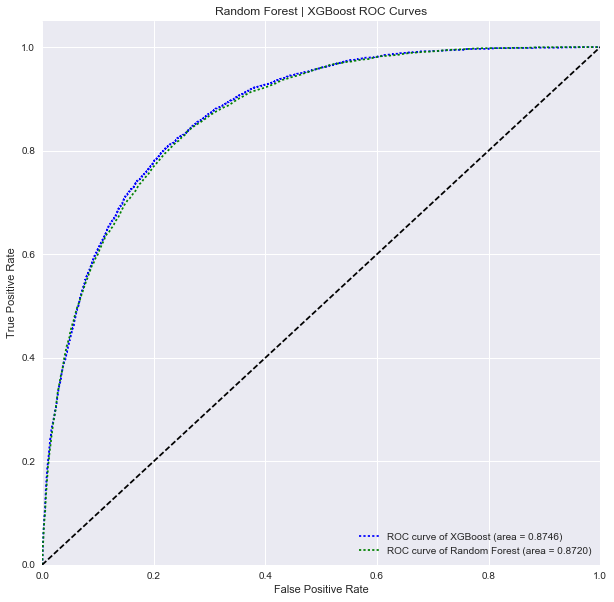

In [230]:
plot_roc([rf, xgb], ['Random Forest', 'XGBoost'], y_test, labels, 'Random Forest | XGBoost ROC Curves')

In [231]:
summary_stats = test_summary_df.iloc[[5, 10, 11, 12, 13]]
summary_stats['model_name'] = summary_stats['model_name'].apply(lambda x: x.split('_')[2] if 'model' in x else x)
summary_stats

/Users/ipatel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,model_name,loss,accuracy,precision,recall,f1
5,combined,1.492047,0.456938,0.445560,0.456938,0.442526
10,pretrained,22.610793,0.345351,0.119267,0.345351,0.177302
11,image,1.841166,0.345351,0.119267,0.345351,0.177302
12,random forest,1.366524,0.510443,0.513855,0.510443,0.476386
13,xgboost,1.372189,0.505579,0.492831,0.505579,0.490922


In [232]:
train = pd.read_csv('train_w_poster_updated_genres.csv')
test = pd.read_csv('test_w_poster_updated_genres.csv')
data = pd.concat([train, test])
print(train.shape)
print(test.shape)
print(data.shape)

(8183, 78)
(3495, 78)
(11678, 78)


In [235]:
train.columns

Index([u'part_of_collection', u'budget', u'popularity',
       u'production_companies', u'release_month', u'release_year', u'revenue',
       u'runtime', u'spoken_languages', u'vote_average', u'vote_count',
       u'animation department', u'art department',
       u'camera and electrical department', u'cast', u'casting department',
       u'costume department', u'distributors', u'editorial department',
       u'music department', u'rating', u'visual effects', u'votes', u'genre',
       u'overview_length', u'tagline_length', u'plot_length',
       u'plot_outline_length', u'mpaa_rating_text_length', u'id',
       u'mpaa_rating_NR', u'mpaa_rating_PG', u'mpaa_rating_PG-13',
       u'mpaa_rating_R', u'overview_cluster_0', u'overview_cluster_1',
       u'overview_cluster_2', u'overview_cluster_3', u'overview_cluster_4',
       u'overview_cluster_5', u'overview_cluster_6', u'tagline_cluster_0',
       u'tagline_cluster_1', u'tagline_cluster_2', u'tagline_cluster_3',
       u'tagline_cluster_4

,genre,genre_count
0,Drama,3943
1,Romance,1693
2,Comedy,1631
3,Action,1284
4,Thriller,1267
5,Horror,1017
6,Family,612
7,Documentary,231


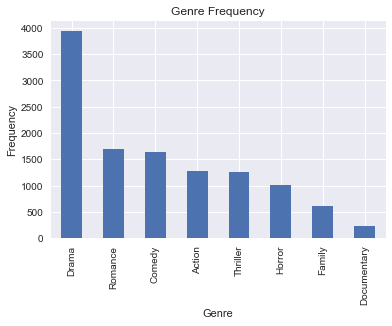

In [234]:
graph_df = pd.DataFrame({})
graph_df['genre'] = data['genre'].value_counts().index
graph_df['genre_count'] = data['genre'].value_counts().tolist()
graph_df.plot(x = 'genre',y = 'genre_count',kind='bar', title='Genre Frequency', legend=False)
plt.xlabel('Genre')
plt.ylabel('Frequency')
graph_df